In [2]:
#data manipulation packages
import pandas as pd
import numpy as np
from scipy import stats
import re

#visualization tools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [3]:
data = pd.read_csv("raw_echo.csv", parse_dates=True)
data.head()

,DataCallTakeoffDateTime,DataCallFlights,DataCallNextFlight,Mcn,DataCallFlightHours,Buno,ActOrg,DetId,DataCallTmrDesc,FailureFlag,CannsFlag,UnscheduledMaintenanceFlag,BeforeFlightAbortFlag,InFlightAbortFlag,CorrosionTreatmentFlag,TransDate,ReceivedDateTime,ActionTakenCode,MalfunctionCode,TransactionCode,TypeMaintenanceCode,WorkCenter,WhenDiscovered,SystemReasonDescription,Discrepancy,CorrectiveAction,TurnAroundDays,ProcessingTimeDays,InWorkTimeDays,ManHours,NmcHours,NmcmHours,NmcsHours,Awm,Wuc2,Emt,YcodeFlag,Eoc,TypeMafCode,Wocat
0,2/13/2015 19:00,2.0,8/10/2017 11:00,18GE66O,4.0,164539,GH9,HOME,TRNG SYL/EXC SP EQUIP,0,0,1,0.0,0.0,0,7/1/2015,7/22/2015 3:31,N,0.0,11,B,20.0,O,"Cannib VALVE, FUEL SYS SO",Cannibalized item POSITION 3 VALVE FUEL SYS SO...,Work order closed out due to transfer new MCN ...,671.625000,0.000000,671.625000,0.1,16120.4,16120.4,0.0,9056.6,46,0.1,0.0,Z,CM,ONEQUIP
1,2/13/2015 19:00,2.0,8/10/2017 11:00,18GE816,4.0,164539,GH9,HOME,TRNG SYL/EXC SP EQUIP,0,0,1,0.0,0.0,0,9/1/2015,9/1/2015 17:41,N,0.0,11,B,20.0,O,Cannib rotary coupl linef,Cannibalized item A1H53CE450400 WP4 PG17 IN233...,Work order closed out due to transfer new MCN ...,630.041667,0.333333,629.708333,0.1,15122.2,15122.2,0.0,13620.2,15,0.1,0.0,Z,CM,ONEQUIP
2,2/13/2015 19:00,2.0,8/10/2017 11:00,18GE88B,4.0,164539,GH9,HOME,TRNG SYL/EXC SP EQUIP,0,0,1,0.0,0.0,0,9/1/2015,9/4/2015 14:42,N,0.0,11,B,20.0,H,#3 TRB,3 TAIL ROTOR BLADE WAS FOUND BAD DURING MALS I...,Work order closed out due to transfer new MCN ...,627.166667,0.041667,627.125000,0.1,15054.2,15054.2,0.0,9056.6,15,0.1,0.0,Z,DM,ONEQUIP
3,2/13/2015 19:00,2.0,8/10/2017 11:00,18GEEAX,4.0,164539,GH9,HOME,TRNG SYL/EXC SP EQUIP,0,0,1,0.0,0.0,0,1/1/2016,1/13/2016 12:12,N,0.0,11,B,20.0,H,FIRE EXT DECAL,ENGINE FIRE EXTINGUISHER SERNO 6321EL INSTALLA...,Work order closed out due to transfer new MCN ...,496.250000,0.000000,496.250000,0.1,11910.6,11910.6,0.0,9242.1,29,0.1,0.0,Z,DM,ONEQUIP
4,5/27/2015 8:30,4.0,6/22/2015 13:00,3303788,6.0,161542,GL8,DEPLOYED,LOG SUPT FMF/CINC,0,1,1,0.0,0.0,0,5/1/2015,5/27/2015 21:11,T,817.0,20,B,200.0,O,CANNI CPL DISC SWITCH 04,CANNIBALIZED ITEM 260400 WP22 F1 IDX29 SWITCH ...,CANNIBALIZED BUNO 164786 MCN 33037DF INSTALLED...,12.250000,6.833333,5.416667,1.0,294.4,102.2,192.2,0.0,15,1.0,0.0,Z,CM,CANN


In [4]:
data.rename({'ReceivedDateTime':'Date'}, axis=1, inplace=True)
data = data.sort_values(by='Date')

#### Time-Series Denoising/Outlier Detection/Normalizing

In [59]:
def plot_wuc(wuc, year=None, by_year=False, include_month=True):
    
    if by_year==True:
         df=data.loc[(data['Wuc2']==wuc) & (data['Date'].dt.year==year)][['Date', 'ManHours']]
    else:
        df=data.loc[data['Wuc2']==wuc][['Date', 'ManHours']]

    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    df.set_index('Date').resample('H').sum()['ManHours'].plot(ax=axes, label='By Hour').set_ylabel('Hours Elapsed', fontsize=14)
    if include_month==True:
        df.set_index('Date').resample('M').sum()['ManHours'].plot(ax=axes, label='By Month').set_ylabel('Hours Elapsed', fontsize=14)
#     df.set_index('Date').resample('Y').sum()['ManHours'].plot(ax=axes, label='By Year').set_ylabel('Hours Elapsed', fontsize=14)
    axes.set_title('Sum ManHours Per Day')
    axes.set_xlabel('Date')
    axes.legend()
    axes.grid()

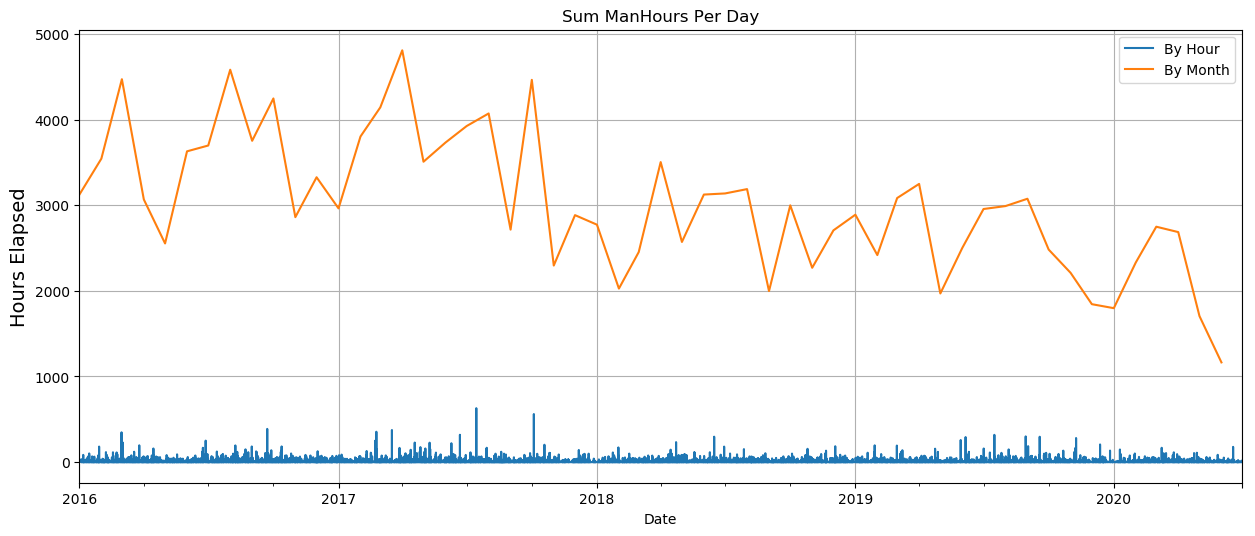

In [210]:
plot_wuc(15, by_year=False, include_month=True)

In [6]:
'''After observing ManHours over time for each Wuc2, it is clear that, for most Wuc2s, the slope in 2015 is
much different than the succeeding years. For that reason, we will remove all data in 2015 - to work with a more
representable data set.'''

data['Date'] = pd.to_datetime(data['Date'])
data = data.loc[data['Date']>='2016-01-01']

In [19]:
'''For some of the Wuc2s, there are only a few observations per year. It may be best to remove these Wuc2s, for such a
small amount of observations won't be enough to generate a reliable model; modeling on Wuc2s with such few observations
will almost always predict zero hours and will be considerably "accurate", but that won't be helpful'''

days = 1640 #the amount of days from the beginning of the data set to the end.

day_percent = {}

for wuc in data['Wuc2'].unique():
    wuc_days = len(data.loc[(data['Wuc2']==wuc)]['Date'].dt.floor('d').unique())
    day_percent['wuc_'+str(wuc)] = round((wuc_days/days)*100,3)

day_percent = {k: v for k, v in sorted(day_percent.items(), key=lambda item: item[1], reverse=True)}
day_percent

{'wuc_15': 94.451,
 'wuc_29': 93.902,
 'wuc_26': 92.012,
 'wuc_22': 87.866,
 'wuc_3': 87.5,
 'wuc_45': 85.671,
 'wuc_13': 82.927,
 'wuc_14': 81.585,
 'wuc_11': 81.402,
 'wuc_46': 80.122,
 'wuc_42': 77.927,
 'wuc_24': 67.866,
 'wuc_57': 67.622,
 'wuc_51': 52.317,
 'wuc_58': 50.549,
 'wuc_97': 44.39,
 'wuc_64': 37.622,
 'wuc_56': 29.207,
 'wuc_71': 23.537,
 'wuc_72': 23.11,
 'wuc_49': 20.305,
 'wuc_12': 19.939,
 'wuc_91': 16.829,
 'wuc_62': 11.89,
 'wuc_10': 11.463,
 'wuc_76': 10.0,
 'wuc_73': 5.0,
 'wuc_65': 4.329,
 'wuc_41': 3.659,
 'wuc_66': 2.805,
 'wuc_44': 2.561,
 'wuc_70': 2.256,
 'wuc_4': 2.073,
 'wuc_61': 1.524,
 'wuc_48': 1.159,
 'wuc_67': 0.732,
 'wuc_75': 0.549,
 'wuc_43': 0.305,
 'wuc_63': 0.244,
 'wuc_69': 0.183,
 'wuc_96': 0.183}

#### Let's index on the Wuc2s that have 10% or more values throughout the time period. This threshold should be enough to generate meaningful, significant models.

In [47]:
viable = [k for k,v in day_percent.items() if v>=10]

data = data[data['Wuc2'].isin([float((re.search(r'\d+',i)).group(0)) for i in viable])]

print('We are now left with {} unique Wuc2 values in our data.'.format(len(data.Wuc2.unique())))

We are now left with 26 unique Wuc2 values in our data.


### Dealing with Datetime and Time-Series Outliers.

In [ ]:
## After preliminary model, consider removing rows where all Wuc2s observe 0 ManHours for the day. Thoeretically,
#it should remove noise and boost score.

In [140]:
'''Since holidays typically have affect on maintenance activity, let's identify the days that land
on holidays. If outliers land on these days, we may need to deal with outliers differently.'''

import holidays
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=data['Date'].dt.date.min(), end=data['Date'].dt.date.max())
holi = data['Date'].dt.date.astype(str).unique()
is_hol = [i for i in holi if i in holidays]

data['is_holiday'] = np.where(data['Date'].dt.date.isin(is_hol),1,0)

0    146016
1      1023
Name: is_holiday, dtype: int64

In [180]:
'''The days leading up to a holiday and the days following them may also effect activity. It may be informative 
to identify those days.'''
days=[1,2,3,4,5]

data = data.assign(**{
    '{}_before_hol'.format(d): np.where((data['Date'].dt.date+datetime.timedelta(days=d)).astype(str).isin(is_hol),1,0)
    for d in days
})

data = data.assign(**{
    '{}_after_hol'.format(d): np.where((data['Date'].dt.date-datetime.timedelta(days=d)).astype(str).isin(is_hol),1,0)
    for d in days
})

##### To remove outliers, we will go through each Wuc2 time series and remove outliers by large positive spikes and additional inconsistancies determined by viual inspection.

In [186]:
data.Wuc2.unique()

array([29, 57, 72, 15,  3, 42, 14, 26, 11, 46, 24, 51, 45, 58, 22, 13, 91,
       64, 56, 49, 97, 76, 71, 62, 10, 12], dtype=int64)

In [202]:
data.loc[(data['Wuc2']==29) & (data['Date'].dt.year==2017)]

,DataCallTakeoffDateTime,DataCallFlights,DataCallNextFlight,Mcn,DataCallFlightHours,Buno,ActOrg,DetId,DataCallTmrDesc,FailureFlag,CannsFlag,UnscheduledMaintenanceFlag,BeforeFlightAbortFlag,InFlightAbortFlag,CorrosionTreatmentFlag,TransDate,Date,ActionTakenCode,MalfunctionCode,TransactionCode,TypeMaintenanceCode,WorkCenter,WhenDiscovered,SystemReasonDescription,Discrepancy,CorrectiveAction,TurnAroundDays,ProcessingTimeDays,InWorkTimeDays,ManHours,NmcHours,NmcmHours,NmcsHours,Awm,Wuc2,Emt,YcodeFlag,Eoc,TypeMafCode,Wocat,is_holiday,1_before_hol,2_before_hol,3_before_hol,4_before_hol,5_before_hol,1_after_hol,2_after_hol,3_after_hol,4_after_hol,5_after_hol
112875,1/1/2017 10:00,6.0,2/10/2017 14:45,1P1MXN8,2.8,161991,GH4,DEPLOYED,LOG SUPT FMF/CINC,0,0,1,0.0,0.0,0,1/1/2017,2017-01-02 10:56:00,B,135.0,12,G,310.0,R,#3 ENG ALPHA CABLE,3 ENGINE ALPHA CABLE KINKED CAUSING BINDING IN...,REMOVED AND REPLACED 3 ENG ALPHA CABLE IAW A1H...,22.666667,13.708333,8.958333,8.2,543.900000,161.400000,382.500000,159.200000,29,2.2,0.0,Z,PF,ONEQUIP,1,0,0,0,0,0,0,0,0,0,0
156655,12/16/2016 7:00,3.0,1/12/2017 10:00,2MEZFD6,5.0,162521,FCC,HOME,SUPT TRANS TRP SCH,0,0,1,0.0,0.0,0,1/1/2017,2017-01-03 11:12:00,C,127.0,11,B,310.0,P,COL BIAS RIGGING,PERFORM COLLECTIVE BIAS CABLE RIGGING FOR ALL ...,PERFORMED COLLECTIVE BIAS CABLE RIGGING IN ACC...,1.083333,0.833333,0.250000,27.7,26.600000,26.600000,0.000000,20.300000,29,6.3,0.0,Z,DM,ONEQUIP,0,0,0,0,0,0,1,0,0,0,0
86583,12/16/2016 7:00,3.0,1/12/2017 10:00,2MEZFD7,5.0,162521,FCC,HOME,SUPT TRANS TRP SCH,0,0,1,0.0,0.0,0,1/1/2017,2017-01-03 11:15:00,C,127.0,11,B,200.0,P,TORQUE CAL,PERFORM TORQUE CALIBRATION ON ALL 3 ENGINES DU...,PERFORMED TORQUE CALIBRATION ON ALL 3 ENGINES ...,0.958333,0.833333,0.125000,3.9,23.600000,23.600000,0.000000,22.400000,29,1.3,0.0,Z,DM,ONEQUIP,0,0,0,0,0,0,1,0,0,0,0
19627,12/16/2016 7:00,3.0,1/12/2017 10:00,2MEZFD8,5.0,162521,FCC,HOME,SUPT TRANS TRP SCH,0,0,1,0.0,0.0,0,1/1/2017,2017-01-03 11:16:00,C,127.0,11,B,200.0,P,2% X3,PERFORM 2 ADJUSTMENTS ON ALL 3 ENGINES DUE TO ...,PERFORMED 2 ADJUSTMENTS ON ALL 3 ENGINES IAW 2...,1.208333,1.208333,0.000000,0.6,29.000000,29.000000,0.000000,28.800000,29,0.3,0.0,Z,DM,ONEQUIP,0,0,0,0,0,0,1,0,0,0,0
136662,1/1/2017 10:00,6.0,2/10/2017 14:45,1P1MXQ2,2.8,161991,GH4,DEPLOYED,LOG SUPT FMF/CINC,0,0,1,0.0,0.0,0,1/1/2017,2017-01-03 12:09:00,C,190.0,11,G,120.0,M,#2 D-RING CRACK,2 EAPS DRING HAS A 1 CRACK ON TOP ALSO ANOTHE...,RPLACED 2 EAPS DRING IAW A1H53CE110000 AREA FO...,13.416667,3.041667,10.375000,9.1,247.600000,166.300000,81.300000,162.600000,29,3.7,0.0,Z,PF,ONEQUIP,0,0,0,0,0,0,1,0,0,0,0
140322,12/15/2016 21:30,3.0,1/6/2017 8:00,18GEYME,3.3,161261,GH9,HOME,TRNG SYL/EXC SP EQUIP,0,0,1,0.0,0.0,0,1/1/2017,2017-01-03 15:46:00,C,190.0,11,B,120.0,H,#3 A/O/B COWLING CRACK,SCIR CHANGE 18GEXSQ THE 3 AFT OUTBOARD COWLI...,3 AFT OUTBOARD COWLING HAS BEEN REPAIRED IAW A...,1.083333,0.666667,0.416667,4.7,25.500000,25.500000,0.000000,21.400000,29,4.0,0.0,Z,DM,ONEQUIP,0,0,0,0,0,0,1,0,0,0,0
176912,11/23/2016 9:00,1.0,2/8/2017 10:45,45Y60XT,3.0,161996,GK4,DEPLOYED,TRNG SYL/EXC FCLP/CAL,0,0,1,0.0,0.0,0,1/1/2017,2017-01-04 04:02:00,C,190.0,11,B,120.0,H,#3 F/I/B LWR KP 190,MULTIPLE RIBS CRACKED ON 3 FORWARD INBOARD FOR...,REPAIRED RIB CRACKS ON 3 FORWARD INBOARD FORWA...,1.791667,0.000000,1.791667,29.7,43.500000,43.500000,0.000000,15.800000,29,27.7,0.0,Z,DM,ONEQUIP,0,0,0,0,0,0,0,1,0,0,0
130518,12/15/2016 14:30,2.0,2/27/2017 7:00,18GEYNE,2.3,161542,GH9,HOME,TRNG SYL/EXC F/F/N,1,0,1,0.0,0.0,0,1/1/2017,2017-01-04 11:22:00,R,190.0,23,G,120.0,M,#2 EAPS,2 EAPS DOORS DO NOT OPEN EAPS BARREL ALSO HAS ...,REPLACED 2 ENGINE AIR PARTICLE SEPARATOR IAW A...,19.000000,0.125000,18.875000,5.7,456.300000,76.900000,379.400000,73.500000,29,3.2,0.0,Z,PF,RMVINST,0,0,0,0,0,0,0,1,0,0,0
103538,1/1/2017 10:00,6.0,2/10/2017 14:45,1P1MXVU,2.8,161991,GH4,DEPLOYED,LOG SUPT FMF/CINC,0,0,1,0.0,0.0,0,1/1/2017,2017-01-04 14:53:00,C,190.0,11,G,120.0,M,#2 FIRE BOTTLE BRKT,2 ENGINE FIRE BOTTLE BRACKET CRACKED O

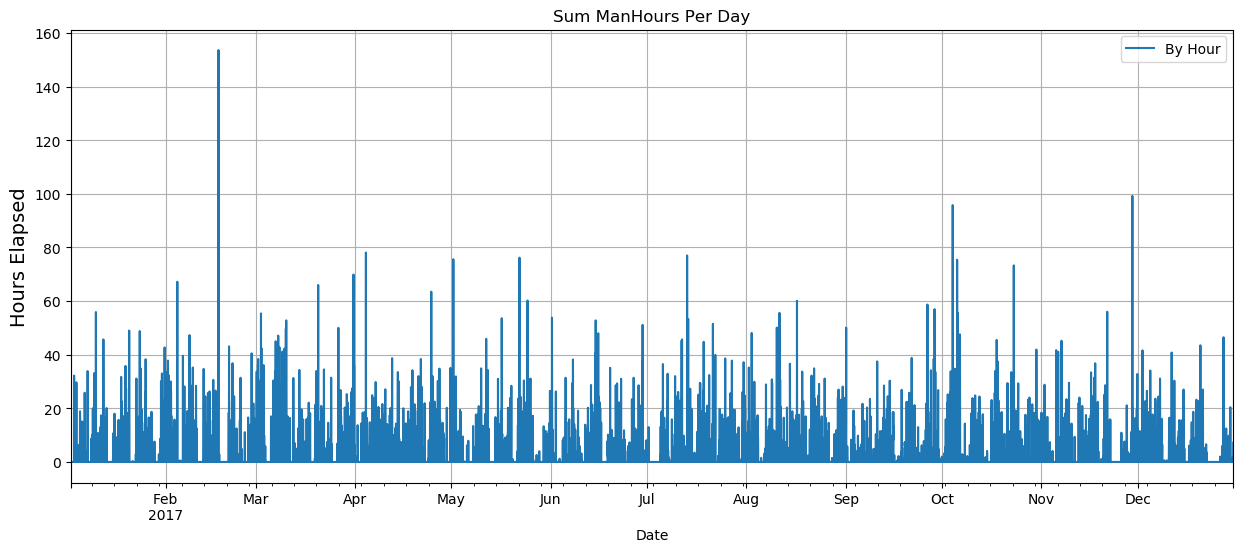

In [209]:
plot_wuc(29, year=2017, by_year=True, include_month=False)

In [ ]:
'''We can deal with ManHours outliers by replacing them with values that are within 2 standard deviations 
of the rolling mean ManHours. We will also check if those outliers occur on or around holidays.'''

def plot_bollinger_bands(item):
    '''bollinger bands around the 50-day rolling mean items sold per day for specified item.
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        line plot of item sale history as well as 50-day rolling standard deviation of the time series (2):
    '''
    item_df = sales.loc[sales['id'] == item][d_cols].T
    item_df = item_df.rename(columns={sales.index[sales['id']==item].to_list()[0]:item}) # Name it correctly
    item_df = item_df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    item_df['mean'] = item_df[item].rolling(window=50).mean()
    item_df['std'] = item_df[item].rolling(window=50).std()
    item_df['upper_band'] = item_df['mean'] + (item_df['std'] * 2)
    item_df['lower_band'] = item_df['mean'] - (item_df['std'] * 2)
    
    item_df[[item, 'mean', 'upper_band', 'lower_band']].plot(figsize=(12,6))
    plt.grid(linestyle='-', linewidth='1')
    plt.title('30 Day Bollinger Band for {}'.format(item))
    plt.ylabel('Items Sold')
    plt.show()

In [ ]:
## try sankey diagram